In [37]:
from mpi4py import MPI
from dolfinx import mesh
from dolfinx.fem import FunctionSpace
from dolfinx import fem
import numpy
import ufl
from dolfinx import default_scalar_type
from dolfinx.fem.petsc import LinearProblem
import pyvista
from dolfinx import plot
print(pyvista.global_theme.jupyter_backend)

panel


In [25]:
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.triangle)

In [26]:
V = FunctionSpace(domain, ("Lagrange", 1))

In [27]:
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

In [28]:
# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

In [29]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

In [30]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, default_scalar_type(-6))

In [31]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [32]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [33]:
V2 = fem.FunctionSpace(domain, ("Lagrange", 2))
uex = fem.Function(V2)
uex.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

In [34]:
L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

In [35]:
error_max = numpy.max(numpy.abs(uD.x.array-uh.x.array))
# Only print the error on one process
if domain.comm.rank == 0:
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_L2 : 8.24e-03
Error_max : 2.00e-15


In [38]:
#Plotting is what we need
pyvista.start_xvfb()
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

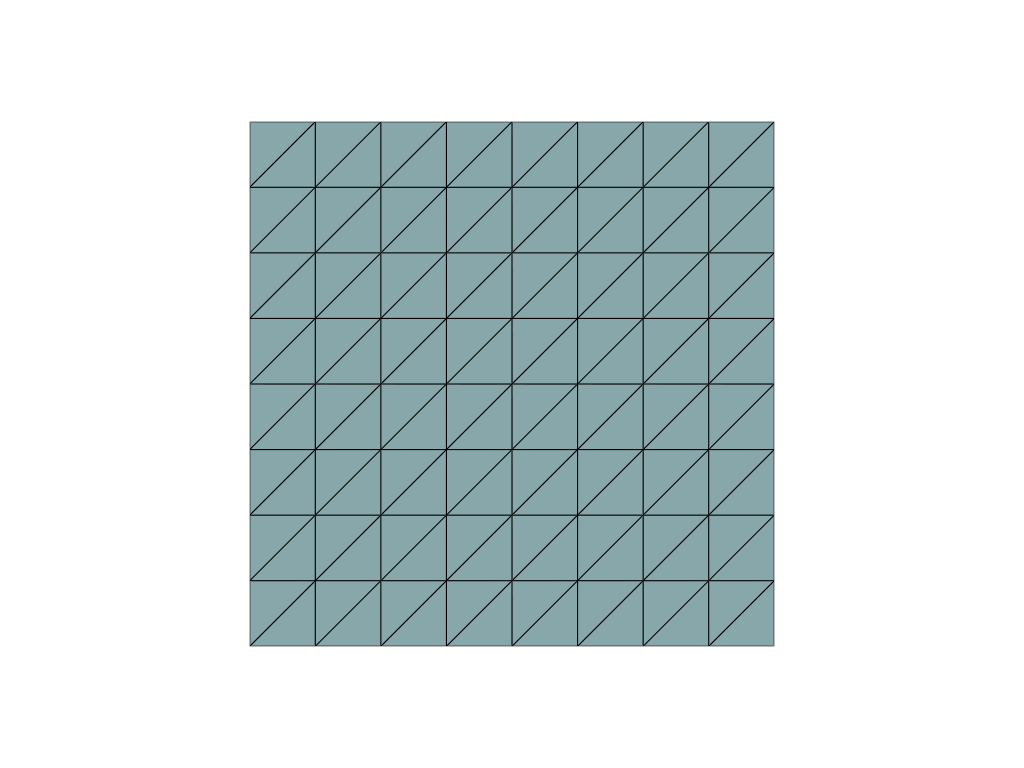

In [39]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

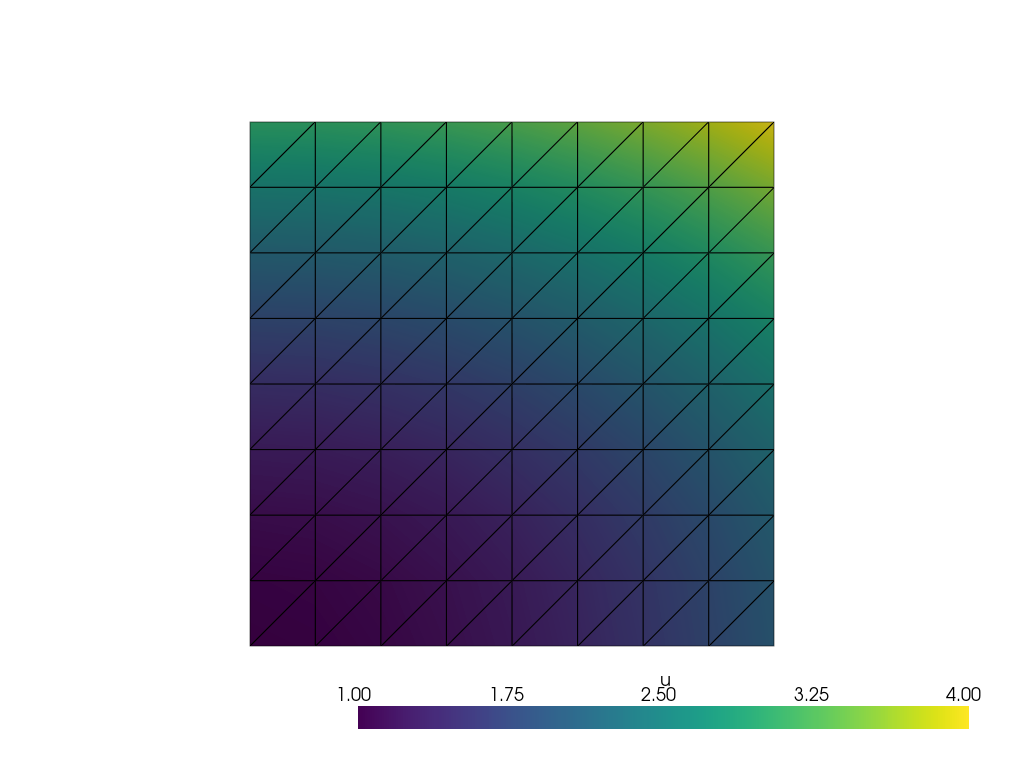

In [40]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()